# Classification de données structurées et textuelles

  L’objectif de ce travail était d’élaborer plusieurs modèles de deep-learning utilisant les titres et abstracts d’un dataset fourni d’articles issus de *PubMed*, afin de prédire par apprentissage supervisé la catégorie thématique associée à chaque article.

  Dans cette partie de notre travail et après récupération de données, nous allons nettoyer et normaliser ces derniers, puis nous utiliserons nos algorithmes d’intelligence artificielle. Dans la deuxième partie (2ème Notebook) nous allons explorer et analyser les données pour montrer l'intérêt de cette étape (Data augmentation).


### Import des libraries

In [0]:
# Pour assurer la reproductibilité des résultats
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.set_random_seed(2)

In [0]:
import numpy as np
from keras.layers import Conv1D, BatchNormalization, GlobalMaxPooling1D, Embedding, MaxPooling1D, concatenate
from keras.layers import Activation, Dense, Dropout, SpatialDropout1D, Flatten, LSTM, Bidirectional, Masking
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import nltk
from nltk import sent_tokenize
import json, random
import pandas as pd
from nltk.stem.porter import PorterStemmer
import matplotlib as mpl

Using TensorFlow backend.


In [0]:
# Les chemins d'accès
ai_pub_samp_path = "/content/drive/My Drive/keras/ai_pub_samp.json"
stop_words_path = "/content/drive/My Drive/keras/stopwords.txt"
glove_300d_path = "/content/drive/My Drive/keras/glove.6B.300d.txt"

### Lien vers le drive

In [0]:
from google.colab import drive

# autorisation avec un code
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Chargement des données 

Toutes les données chargées se situent dans le répertoire `/content/`. 
Les données sont dans un fichier JSON.

In [0]:
with open(ai_pub_samp_path, 'r') as file:
    data_pubmed = json.load(file)
print('les données ont été bien chargées')

les données ont été bien chargées


### Extraire les titres, les abstracts et les catégories thématiques

In [0]:
print(f" Le dataset contient {len(data_pubmed)} articles scientifiques")

 Le dataset contient 10000 articles scientifiques


In [0]:
# mettre le titre en minuscule dans la variable X1
X1 = [index['title'][:-1].lower() for index in data_pubmed] # il ne faut pas prendre le dernier element qui est un point '.'

# mettre l'abstract dans la variable X2
X2 = [index['abstract'][:-1].lower() for index in data_pubmed] # il ne faut pas prendre le dernier element qui est un point '.'

# mettre la catégorie dans la variable Y
Y = [index['categories'][0] for index in data_pubmed]

### Calcul de la longueur maximale des titres et des abstracts dans le dataset

In [0]:
title_max_len_cars = len((max(X1, key=len)))
title_max_len_words = len(max(X1, key=len).split())
abstract_max_len_cars = len((max(X2, key=len)))
abstract_max_len_words = len(max(X2, key=len).split())

In [0]:
print(f'Le nombre max des mots dans un titre est : {title_max_len_words}')
print(f'Le nombre max des mots dans un abstract est : {abstract_max_len_words}')

Le nombre max des mots dans un titre est : 37
Le nombre max des mots dans un abstract est : 1495


### La division de dataset en train (X_train, Y_train) et test (X_test, Y_test)
1. Pour les titres
2. Pour les abstracts

In [0]:
# utilisation de la fonction train_test_split pour séparer le dataset
X_train, X_test, Y_train, Y_test =  train_test_split(pd.DataFrame([X1, X2]).T, Y, test_size = 0.2, random_state = 4)
X_train_title, X_train_abstract = list(X_train[0]), list(X_train[1])
X_test_title, X_test_abstract = list(X_test[0]), list(X_test[1])

### La normalisation des données
#### 1. Les catégories

Le but est de transformer les textes en une variable numérique

texte -> variable numérique

"Biology" -> 1

"Medical" -> 2

In [0]:
# La transformation de la variable Y 'les catégories' en variable numérique
cat_to_index={'<UNK>':0}
for cat in Y_train:
    if cat not in cat_to_index.keys():
      cat_to_index[cat]=len(cat_to_index)
index_to_cat={v: k for k, v in cat_to_index.items()}

def preprocess_Y(Y, cat_to_index):
  res = []
  for ex in Y:
    if ex not in cat_to_index.keys():
      res.append(cat_to_index['<UNK>'])
    else:
      res.append(cat_to_index[ex])
  return np.array(res)

Y_train_id = preprocess_Y(Y_train, cat_to_index)
Y_test_id = preprocess_Y(Y_test, cat_to_index)

### 2. Les titres et les abstracts

### A. Première passe de nettoyage : supprimer les stopwords 

  La première manipulation est la suppression de ce qu'on appelle en anglais les stopwords. Ce sont les mots très courants dans la langue étudiée ("et", "à", "le"... en français) qui n'apportent pas de valeur informative pour la compréhension du "sens" d'un document et corpus. Il sont très fréquents et ralentissent notre travail : nous souhaitons donc les supprimer.



In [0]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
with open(stop_words_path, 'r') as file:
    stop_words = (file.read()).split()
    
def remove_stop_words(data, stop_words):
  for a in range(len(data)):
    word_tokens = word_tokenize(data[a])
    data[a] = ' '.join([w for w in word_tokens if not w in stop_words])
  return data

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
# X_train_title
X_train_title = remove_stop_words(X_train_title, stop_words)

In [0]:
# X_test_abstract
X_train_abstract = remove_stop_words(X_train_abstract, stop_words)

In [0]:
# X_test_title
X_test_title = remove_stop_words(X_test_title, stop_words)

In [0]:
# X_test_abstract
X_test_abstract = remove_stop_words(X_test_abstract, stop_words)

Après élimination des stop words

In [0]:
title_max_len_cars = max(len((max(X_train_title, key=len))), len((max(X_test_title, key=len))))
title_max_len_words = max(len(max(X_train_title, key=len).split()), len(max(X_test_title, key=len).split()))
abstract_max_len_cars = max(len((max(X_train_abstract, key=len))), len((max(X_test_abstract, key=len))))
abstract_max_len_words = max(len(max(X_train_abstract, key=len).split()), len(max(X_test_abstract, key=len).split()))

In [0]:
print(f'Le nombre max des mots dans un titre est : {title_max_len_words}')
print(f'Le nombre max des mots dans un abstract est : {abstract_max_len_words}')

Le nombre max des mots dans un titre est : 34
Le nombre max des mots dans un abstract est : 1032


### B. Deuxième passe: Création des séquences et padding

Le but est de transformer les textes en un vecteur numérique de taille fixe


Pour les titres

In [0]:
tokenizer_title = tf.keras.preprocessing.text.Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ')
tokenizer_title.fit_on_texts(X_train_title)

word_index_title = tokenizer_title.word_index
word_counts_title = tokenizer_title.word_counts
document_count_title = tokenizer_title.document_count
word_docs_title = tokenizer_title.word_docs

# Transformer les textes en vecteurs numeriques à l'aide du tokenizer
X_train_title_seq = tokenizer_title.texts_to_sequences(X_train_title)
X_test_title_seq = tokenizer_title.texts_to_sequences(X_test_title)

# Padding des sequences
X_train_title_seq = sequence.pad_sequences(X_train_title_seq, maxlen = 40, padding = 'post', truncating='post')
X_test_title_seq = sequence.pad_sequences(X_test_title_seq, maxlen = 40, padding = 'post', truncating='post')

Pour les abstracts

In [0]:
tokenizer_abstract = tf.keras.preprocessing.text.Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ')
tokenizer_abstract.fit_on_texts(X_train_abstract)

word_index_abstract = tokenizer_abstract.word_index
word_counts_abstract = tokenizer_abstract.word_counts
document_count_abstract = tokenizer_abstract.document_count
word_docs_abstract = tokenizer_abstract.word_docs

# Transformer les textes en vecteurs numeriques à l'aide du tokenizer
X_train_abstract_seq = tokenizer_abstract.texts_to_sequences(X_train_abstract)
X_test_abstract_seq = tokenizer_abstract.texts_to_sequences(X_test_abstract)

# Padding des sequences
X_train_abstract_seq = tf.keras.preprocessing.sequence.pad_sequences(X_train_abstract_seq, maxlen = 1200, padding = 'post', truncating='post')
X_test_abstract_seq = tf.keras.preprocessing.sequence.pad_sequences(X_test_abstract_seq, maxlen = 1200, padding = 'post', truncating='post')


### Utilisation des embedding pré-entrainés

Pour améliorer la qualité de la représentation des mots, il est possible d'entrainer les embeddings sur de larges corpus de textes non annotés. 
Ici nous allons utiliser des embeddings de taille 300d

In [0]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1 
    embedding_matrix = np.random.uniform(-0.25, 0.25, (vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [0]:
embedding_dim = 300
embedding_matrix_abstract = create_embedding_matrix(glove_300d_path, word_index_abstract, embedding_dim)
embedding_matrix_title = create_embedding_matrix(glove_300d_path, word_index_title, embedding_dim)

### Entrainement des modèles

### 1. Titres seuls

CNN : Réseau neuronal convolutif

In [0]:
EMBED_DIM = 256
LSTM_OUT = 128
BATCH_SIZE = 128
OUTPUT = len(cat_to_index)
INPUT_LENGTH_TITLE = X_train_title_seq.shape[1]
INPUT_LENGTH_ABSTRACT = X_train_abstract_seq.shape[1]
VALIDATION_SPLIT = 0.2
VERBOSE = 1
INPUT_DIM_TITLE = len(word_counts_title) + 1
INPUT_DIM_ABSTRACT = len(word_counts_abstract) + 1
FILTERS = 200
KERNEL_SIZE = 3

2000/2000 [==============================] - 0s 63us/step
les résultats :[0.3545, 0.352, 0.3605, 0.3535, 0.355]
 pour les valeurs de batch size : [32, 64, 128, 256, 512]


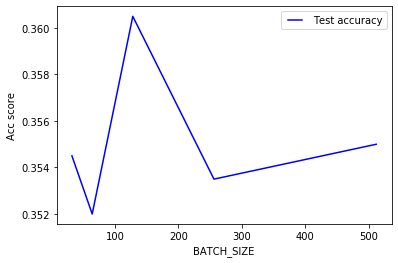

In [0]:
# Dans cet exemple nous allons utiliser des boucles pour vous montrer comment les hyperparamètres ont été fixés
# Définir le modèle
BATCH_SIZE_LIST = [32, 64, 128, 256, 512]
test_results = []
for batch in BATCH_SIZE_LIST:
  model_CNN_title = Sequential()
  model_CNN_title.add(Embedding(embedding_matrix_title.shape[0], embedding_matrix_title.shape[1], 
                            input_length = INPUT_LENGTH_TITLE, 
                            weights=[embedding_matrix_title], 
                            trainable=True))
  model_CNN_title.add(Conv1D(filters = FILTERS, kernel_size = KERNEL_SIZE))
  model_CNN_title.add(BatchNormalization(axis=-1))
  model_CNN_title.add(Activation('relu'))
  model_CNN_title.add(Dropout(0.1))
  model_CNN_title.add(GlobalMaxPooling1D())
  model_CNN_title.add(Dense(OUTPUT))
  model_CNN_title.add(Activation('softmax'))
  #print(model_CNN_title.summary())

  # Compiler le modèle
  model_CNN_title.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  history = model_CNN_title.fit(X_train_title_seq, Y_train_id,  epochs = 5,
                                  verbose = None, validation_split = VALIDATION_SPLIT, batch_size = batch)
  score = model_CNN_title.evaluate(X_test_title_seq, Y_test_id)
  test_results.append(score[1])
print(f'les résultats :{test_results}')
print(f' pour les valeurs de batch size : {BATCH_SIZE_LIST}')

# Plot pour visualiser 
from matplotlib.legend_handler import HandlerLine2D
line2, = plt.plot(BATCH_SIZE_LIST, test_results, 'b', label= "Test accuracy")
plt.legend(handler_map={line2: HandlerLine2D(numpoints=2)})
plt.ylabel('Acc score')
plt.xlabel('BATCH_SIZE')
plt.show()

Bidirectional LSTM

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_37 (Embedding)     (None, 40, 300)           3650400   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 40, 300)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               439296    
_________________________________________________________________
dropout_37 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 97)                24929     
_________________________________________________________________
activation_72 (Activation)   (None, 97)                0         
Total params: 4,114,625
Trainable params: 4,114,625
Non-trainable params: 0
___________________________________________

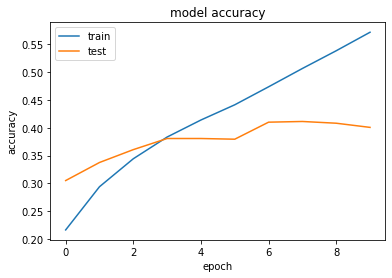

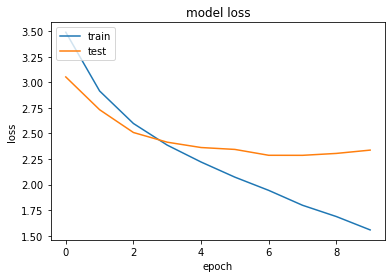

In [0]:
# Definir le modèle
model_LSTM_title = Sequential()
model_LSTM_title.add(Embedding(embedding_matrix_title.shape[0], embedding_matrix_title.shape[1], 
                          input_length = INPUT_LENGTH_TITLE, 
                          weights=[embedding_matrix_title], 
                          trainable=True))
model_LSTM_title.add(SpatialDropout1D(0.5))
model_LSTM_title.add(Bidirectional(LSTM(LSTM_OUT)))
model_LSTM_title.add(Dropout(0.2))
model_LSTM_title.add(Dense(OUTPUT))
model_LSTM_title.add(Activation('softmax'))
print(model_LSTM_title.summary())

# Compiler le modèle
model_LSTM_title.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_LSTM_title.fit(X_train_title_seq, Y_train_id,  epochs = 10,  verbose = VERBOSE, 
                                 validation_split=VALIDATION_SPLIT, batch_size = BATCH_SIZE)
score = model_LSTM_title.evaluate(X_test_title_seq, Y_test_id)
print('Test score:', score[0])
print('Test accuracy:', score[1])

# Liste de données dans l'historique
print(history.history.keys())

# Plot pour comparer accuracy et validate accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

# Plot pour comparer loss et validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

In [0]:
# Nuage tfprojector pour Bidirectional LSTM 
e = model_LSTM_title.layers[0]
weights = e.get_weights()[0]
print(weights.shape)
import io

#encoder = info.features['text'].encoder
out_v = io.open('/content/drive/My Drive/keras/vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('/content/drive/My Drive/keras/meta.tsv', 'w', encoding='utf-8')
for num, word in enumerate(word_index_title):
  vec = weights[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

(12168, 300)


### 2. Abstracts seuls

CNN : Réseau neuronal convolutif

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1200, 300)         12193200  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1198, 200)         180200    
_________________________________________________________________
batch_normalization_2 (Batch (None, 1198, 200)         800       
_________________________________________________________________
activation_3 (Activation)    (None, 1198, 200)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1198, 200)         0         
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 97)               

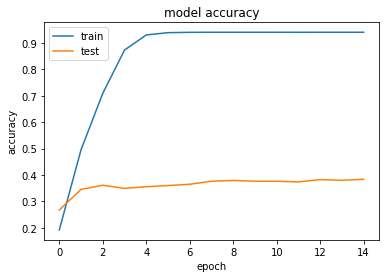

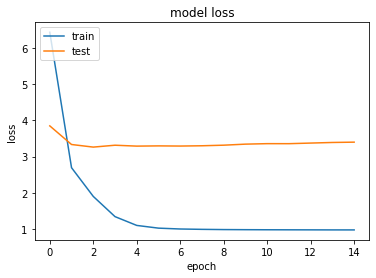

[[0 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.11      0.07      0.09        58
           2       0.00      0.00      0.00         2
           3       0.20      0.25      0.22         4
           4       0.00      0.00      0.00        25
           5       0.65      0.71      0.68       125
           6       0.12      0.07      0.09        40
           7       0.51      0.59      0.55       100
           8       0.44      0.75      0.55       113
           9       0.43      0.34      0.38        74
          10       0.33      0.60      0.43       369
          11       0.43      0.33      0.38        39
          12       0.00      0.00      0.00        20
          13       0.00      0.00      0.00         8
          14       0.00      0.00      0.00        13
          15   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
# Définir le modèle
model_CNN_abstract = Sequential()
model_CNN_abstract.add(Embedding(embedding_matrix_abstract.shape[0], embedding_matrix_abstract.shape[1], 
                       input_length = INPUT_LENGTH_ABSTRACT, 
                       weights=[embedding_matrix_abstract], 
                       trainable=True))
model_CNN_abstract.add(Conv1D(filters = FILTERS, kernel_size = KERNEL_SIZE))
model_CNN_abstract.add(BatchNormalization(axis=-1))
model_CNN_abstract.add(Activation('relu'))
model_CNN_abstract.add(Dropout(0.1))
model_CNN_abstract.add(GlobalMaxPooling1D())
model_CNN_abstract.add(Dense(OUTPUT))
model_CNN_abstract.add(Activation('softmax'))
print(model_CNN_abstract.summary())

# Compiler le modèle
model_CNN_abstract.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_CNN_abstract.fit(X_train_abstract_seq, Y_train_id,  epochs = 15,  verbose = VERBOSE, 
                                 validation_split = VALIDATION_SPLIT, batch_size = BATCH_SIZE)
score = model_CNN_abstract.evaluate(X_test_abstract_seq, Y_test_id)
print('Test score:', score[0])
print('Test accuracy:', score[1])

# Liste de données dans l'historique
print(history.history.keys())

# Plot pour comparer accuracy et validate accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

# Plot pour comparer loss et validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

# Matrice de confusion
from sklearn.metrics import classification_report, confusion_matrix
predicted_classes = model_CNN_abstract.predict_classes(X_test_abstract_seq)
print(confusion_matrix(Y_test_id, predicted_classes))
print(classification_report(Y_test_id, predicted_classes))

Bidirectional LSTM

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1200, 300)         12193200  
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 1200, 300)         0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               439296    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 97)                24929     
_________________________________________________________________
activation_6 (Activation)    (None, 97)                0         
Total params: 12,657,425
Trainable params: 12,657,425
Non-trainable params: 0
__________________________________________

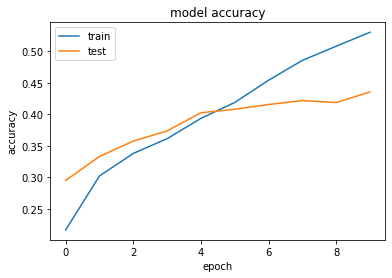

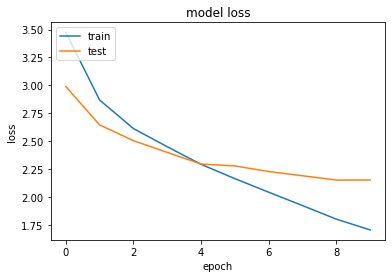

In [0]:
# Définir le modèle
model_LSTM_abstract = Sequential()
model_LSTM_abstract.add(Embedding(embedding_matrix_abstract.shape[0], embedding_matrix_abstract.shape[1], 
                                  input_length = INPUT_LENGTH_ABSTRACT, 
                                  weights=[embedding_matrix_abstract], 
                                  trainable=True))
model_LSTM_abstract.add(SpatialDropout1D(0.5))
model_LSTM_abstract.add(Bidirectional(LSTM(LSTM_OUT)))
model_LSTM_abstract.add(Dropout(0.2))
model_LSTM_abstract.add(Dense(OUTPUT))
model_LSTM_abstract.add(Activation('softmax'))
print(model_LSTM_abstract.summary())

# Compiler le modèle
model_LSTM_abstract.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_LSTM_abstract.fit(X_train_abstract_seq, Y_train_id,  epochs = 10,  verbose = VERBOSE, 
                                  validation_split=VALIDATION_SPLIT, batch_size = BATCH_SIZE)
score = model_LSTM_abstract.evaluate(X_test_abstract_seq, Y_test_id)
print('Test score:', score[0])
print('Test accuracy:', score[1])

# Liste de données dans l'historique
print(history.history.keys())

# Plot pour comparer accuracy et validate accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

# Plot pour comparer loss et validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

### 3.  Titres et Abstracts

CNN avec 2 inputs



Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_13_input (InputLayer) (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_14_input (InputLayer) (None, 1200)         0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 40, 300)      3650400     embedding_13_input[0][0]         
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, 1200, 300)    12193200    embedding_14_input[0][0]         
____________________________________________________________________________________________

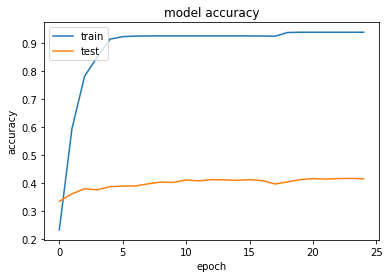

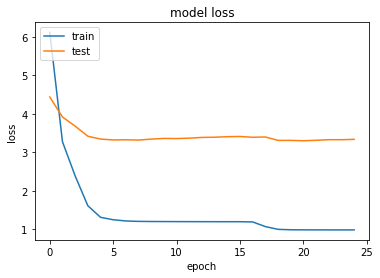

In [0]:
# Entrée 01 
model_title = Sequential()
model_title.add(Embedding(embedding_matrix_title.shape[0], embedding_matrix_title.shape[1], 
                          input_length = INPUT_LENGTH_TITLE, 
                          weights=[embedding_matrix_title], 
                          trainable=True))
model_title.add(Conv1D(filters = FILTERS, kernel_size = KERNEL_SIZE))
model_title.add(BatchNormalization(axis=-1))
model_title.add(Activation('relu'))
model_title.add(Dropout(0.1))
model_title.add(GlobalMaxPooling1D())

# Entrée 02
model_abstract = Sequential()
model_abstract.add(Embedding(embedding_matrix_abstract.shape[0], embedding_matrix_abstract.shape[1], 
                          input_length = INPUT_LENGTH_ABSTRACT, 
                          weights=[embedding_matrix_abstract], 
                          trainable=True))
model_abstract.add(Conv1D(filters = FILTERS, kernel_size = KERNEL_SIZE))
model_abstract.add(BatchNormalization(axis=-1))
model_abstract.add(Activation('relu'))
model_abstract.add(Dropout(0.1))
model_abstract.add(GlobalMaxPooling1D())

# Concaténation
concat_layers = concatenate([model_title.output, model_abstract.output], axis=-1)
layer = Dense(OUTPUT)(concat_layers)
outlayer = Activation('softmax')(layer)
model = Model([model_title.input, model_abstract.input], [outlayer])


# Compilation
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())
history = model.fit([np.array(X_train_title_seq), np.array(X_train_abstract_seq)], np.array(Y_train_id), batch_size = BATCH_SIZE, epochs = 25,
verbose = VERBOSE, validation_split = VALIDATION_SPLIT)
score = model.evaluate([np.array(X_test_title_seq), np.array(X_test_abstract_seq)], np.array(Y_test_id), verbose = VERBOSE)
print("Test loss:", score[0])
print('Test accuracy:', score[1])

# Liste de données dans l'historique
print(history.history.keys())

# Plot pour comparer accuracy et validate accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

# Plot pour comparer loss et validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

LSTM avec 2 inputs

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_13_input (InputLayer) (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_14_input (InputLayer) (None, 1200)         0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 40, 300)      3650400     embedding_13_input[0][0]         
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, 1200, 300)    12193200    embedding_14_input[0][0]         
____________________________________________________________________________________________

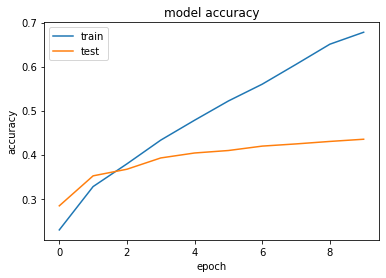

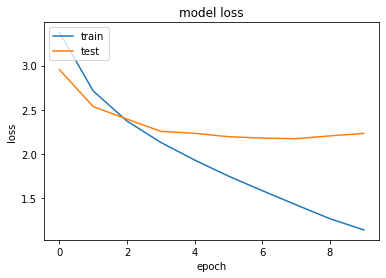

In [0]:
# Entrée 01
model_title = Sequential()
model_title.add(Embedding(embedding_matrix_title.shape[0], embedding_matrix_title.shape[1], input_length = INPUT_LENGTH_TITLE,
                          weights=[embedding_matrix_title], 
                          trainable=True,
                          ))
model_title.add(SpatialDropout1D(0.5))
model_title.add(Bidirectional(LSTM(LSTM_OUT)))
model_title.add(Dropout(0.2))

# Entrée 02
model_abstract = Sequential()
model_abstract.add(Embedding(embedding_matrix_abstract.shape[0], embedding_matrix_abstract.shape[1], input_length = INPUT_LENGTH_ABSTRACT,
                           weights=[embedding_matrix_abstract], 
                           trainable=True
                             ))
model_abstract.add(SpatialDropout1D(0.5))
model_abstract.add(Bidirectional(LSTM(LSTM_OUT)))
model_abstract.add(Dropout(0.2))

# Concaténation
concat_layers = concatenate([model_title.output, model_abstract.output], axis=-1)
layer = Dense(OUTPUT)(concat_layers)
outlayer = Activation('softmax')(layer)
model = Model([model_title.input, model_abstract.input], [outlayer])

# Compilation
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())
history = model.fit([np.array(X_train_title_seq), np.array(X_train_abstract_seq)], np.array(Y_train_id), batch_size = 128, epochs = 10,
verbose = VERBOSE, validation_split = VALIDATION_SPLIT)
score = model.evaluate([np.array(X_test_title_seq), np.array(X_test_abstract_seq)], np.array(Y_test_id), verbose = VERBOSE)
print("Test loss:", score[0])
print('Test accuracy:', score[1])

# list de données dans l'historique
print(history.history.keys())

# plot pour comparer accuracy et validate accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

# plot pour comparer loss et validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

### Autres modèles: 
Dans cette partie nous allons explorer quelques modèles parmi  ceux que nous avons utilisés avant de fixer notre choix

### 1. Embedding et GlobalMaxPooling1D





In [0]:
# Model avec Embedding et GlobalMaxPooling1D
# Définir le modèle
model_EMBED_MAX = Sequential()
model_EMBED_MAX.add(Embedding(INPUT_DIM_TITLE, EMBED_DIM, input_length = INPUT_LENGTH_TITLE))
model_EMBED_MAX.add(GlobalMaxPooling1D())
model_EMBED_MAX.add(Dense(OUTPUT))
model_EMBED_MAX.add(Activation('softmax'))
model_EMBED_MAX.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model_EMBED_MAX.summary())
# Compiler le modèle
history = model_EMBED_MAX.fit(X_train_title_seq, Y_train_id,  epochs = 10,  verbose = VERBOSE, 
                                  validation_split = VALIDATION_SPLIT, batch_size = BATCH_SIZE)
# Evaluer le modèle
score = model_EMBED_MAX.evaluate(np.array(X_test_title_seq), np.array(Y_test_id), verbose = VERBOSE)
print("Test loss:", score[0])
print('Test accuracy:', score[1])

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_47 (Embedding)     (None, 40, 256)           3115008   
_________________________________________________________________
global_max_pooling1d_45 (Glo (None, 256)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 97)                24929     
_________________________________________________________________
activation_86 (Activation)   (None, 97)                0         
Total params: 3,139,937
Trainable params: 3,139,937
Non-trainable params: 0
_________________________________________________________________
None
Train on 6400 samples, validate on 1600 samples
Epoch 1/10
6400/6400 [==============================] - 7s 1ms/step - loss: 4.2504 - acc: 0.2017 - val_loss: 3.8740 - val_acc: 0.2106
Epoch 2/10
6400/6400 [==============================] 

### 2. LSTM simple

In [0]:
# Définir le modèle
model_LSTM_simple = Sequential()
model_LSTM_simple.add(Embedding(INPUT_DIM_TITLE, EMBED_DIM, 
                          input_length = INPUT_LENGTH_TITLE))
model_LSTM_simple.add(LSTM(LSTM_OUT))

# Fully connected layer
model_LSTM_simple.add(Dense(256, activation='relu'))
model_LSTM_simple.add(Dropout(0.3))

# Plus ou moins quelques couches cachées (Dense)
model_LSTM_simple.add(Dense(OUTPUT))
model_LSTM_simple.add(Activation("sigmoid"))
model_LSTM_simple.compile(loss="sparse_categorical_crossentropy", optimizer="adam",
    metrics=["accuracy"])
print(model_LSTM_simple.summary())

# Compiler le modèle
model_LSTM_simple.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_LSTM_simple.fit(X_train_title_seq, Y_train_id,  epochs = 5,  verbose = 1, 
                                  validation_split=VALIDATION_SPLIT, batch_size = BATCH_SIZE)
score = model_LSTM_simple.evaluate(X_test_title_seq, Y_test_id)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_56 (Embedding)     (None, 40, 256)           3115008   
_________________________________________________________________
lstm_10 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dense_58 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_46 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_59 (Dense)             (None, 97)                24929     
_________________________________________________________________
activation_94 (Activation)   (None, 97)                0         
Total params: 3,370,081
Trainable params: 3,370,081
Non-trainable params: 0
___________________________________________

### 3. CNN-LSTM

Nous allons testé cette combinaison avec les abstracts

Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_53 (Embedding)     (None, 1200, 256)         10404864  
_________________________________________________________________
dropout_53 (Dropout)         (None, 1200, 256)         0         
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 1198, 200)         153800    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 119, 200)          0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 128)               168448    
_________________________________________________________________
dropout_54 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 97)              

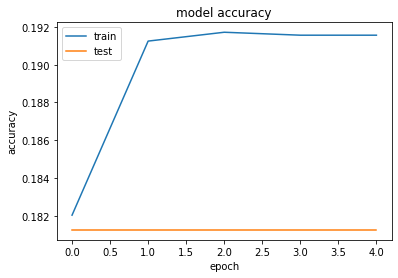

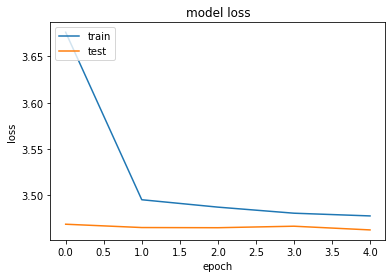

In [0]:
# Définir le modèle
model_LSTM_CNN_abstract = Sequential()
model_LSTM_CNN_abstract.add(Embedding(INPUT_DIM_ABSTRACT, EMBED_DIM, 
                                  input_length = INPUT_LENGTH_ABSTRACT))
model_LSTM_CNN_abstract.add(Dropout(0.25))
model_LSTM_CNN_abstract.add(Conv1D(FILTERS,
                 KERNEL_SIZE,
                 padding='valid',
                 activation='relu',
                 strides=1))
model_LSTM_CNN_abstract.add(MaxPooling1D(10))
model_LSTM_CNN_abstract.add(LSTM(LSTM_OUT))
model_LSTM_CNN_abstract.add(Dropout(0.2))
model_LSTM_CNN_abstract.add(Dense(OUTPUT))
model_LSTM_CNN_abstract.add(Activation('softmax'))
print(model_LSTM_CNN_abstract.summary())

# Compiler le modèle
model_LSTM_CNN_abstract.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_LSTM_CNN_abstract.fit(X_train_abstract_seq, Y_train_id,  epochs = 5,  verbose = 1, 
                                  validation_split=VALIDATION_SPLIT, batch_size = BATCH_SIZE)
score = model_LSTM_CNN_abstract.evaluate(X_test_abstract_seq, Y_test_id)
print('Test score:', score[0])
print('Test accuracy:', score[1])

# Liste de données dans l'historique
print(history.history.keys())

# Plot pour comparer accuracy et validate accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

# Plot pour comparer loss et validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

### 4. LSTM ET CNN (2 inputs)

In [0]:
# Entrée 01
model_title = Sequential()
model_title.add(Embedding(embedding_matrix_title.shape[0], embedding_matrix_title.shape[1], input_length = INPUT_LENGTH_TITLE,
                          weights=[embedding_matrix_title], 
                          trainable=True,
                          ))
model_title.add(SpatialDropout1D(0.5))
model_title.add(Bidirectional(LSTM(LSTM_OUT)))
model_title.add(Dropout(0.2))

# Entrée 02

model_abstract = Sequential()
model_abstract.add(Embedding(embedding_matrix_abstract.shape[0], embedding_matrix_abstract.shape[1], input_length = INPUT_LENGTH_ABSTRACT,
                           weights=[embedding_matrix_abstract], 
                           trainable=True
                             ))
model_abstract.add(Conv1D(filters = FILTERS, kernel_size = KERNEL_SIZE))
model_abstract.add(BatchNormalization(axis=-1))
model_abstract.add(Activation('relu'))
model_abstract.add(Dropout(0.1))
model_abstract.add(GlobalMaxPooling1D())

# Concaténation
concat_layers = concatenate([model_title.output, model_abstract.output], axis=-1)
layer = Dense(OUTPUT)(concat_layers)
outlayer = Activation('softmax')(layer)
model = Model([model_title.input, model_abstract.input], [outlayer])


# Compilation
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())
history = model.fit([np.array(X_train_title_seq), np.array(X_train_abstract_seq)], np.array(Y_train_id), batch_size = 128, epochs = 20,
verbose = VERBOSE, validation_split = VALIDATION_SPLIT)
score = model.evaluate([np.array(X_test_title_seq), np.array(X_test_abstract_seq)], np.array(Y_test_id), verbose = VERBOSE)
print("Test loss:", score[0])
print('Test accuracy:', score[1])

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_11_input (InputLayer) (None, 1200)         0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 1200, 300)    12193200    embedding_11_input[0][0]         
__________________________________________________________________________________________________
embedding_10_input (InputLayer) (None, 40)           0                                            
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 1198, 200)    180200      embedding_11[0][0]               
____________________________________________________________________________________________

### La racinisation (stemming)

  Le processus de « stemming » consiste à représenter les mots sous leur forme 
canonique. Dans notre cas, ce processus a diminué l'accuracy une fois combiné avec Glove 

In [0]:
# Pour stemmer
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()

def words_stemming(list_of_sentences):
  for sentence in range(len(list_of_sentences)):
    word_tokens = word_tokenize(list_of_sentences[sentence])
    list_of_sentences[sentence] = ' '.join([porter.stem(word) for word in word_tokens])
  return list_of_sentences

In [0]:
# X_train_title
X_train_title = words_stemming(X_train_title)
# X_train_abstract
X_train_abstract = words_stemming(X_train_abstract)
# X_test_title
X_test_title = words_stemming(X_test_title)
# X_test_abstract
X_test_abstract = words_stemming(X_test_abstract)

In [0]:
title_max_len_cars = max(len((max(X_train_title, key=len))), len((max(X_test_title, key=len))))
title_max_len_words = max(len(max(X_train_title, key=len).split()), len(max(X_test_title, key=len).split()))
abstract_max_len_cars = max(len((max(X_train_abstract, key=len))), len((max(X_test_abstract, key=len))))
abstract_max_len_words = max(len(max(X_train_abstract, key=len).split()), len(max(X_test_abstract, key=len).split()))

print(f'Le nombre max des mots dans un titre est : {title_max_len_words}')
print(f'Le nombre max des mots dans un abstract est : {abstract_max_len_words}')

Le nombre max des mots dans un titre est : 34
Le nombre max des mots dans un abstract est : 1032


In [0]:
tokenizer_title = tf.keras.preprocessing.text.Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ')
tokenizer_title.fit_on_texts(X_train_title)

word_index_title = tokenizer_title.word_index
word_counts_title = tokenizer_title.word_counts
document_count_title = tokenizer_title.document_count
word_docs_title = tokenizer_title.word_docs

# Transformer les textes en vecteurs numeriques à l'aide du tokenizer
X_train_title_seq = tokenizer_title.texts_to_sequences(X_train_title)
X_test_title_seq = tokenizer_title.texts_to_sequences(X_test_title)

# Padding des sequences
X_train_title_seq = sequence.pad_sequences(X_train_title_seq, maxlen = 40, padding = 'post', truncating='post')
X_test_title_seq = sequence.pad_sequences(X_test_title_seq, maxlen = 40, padding = 'post', truncating='post')

In [0]:

tokenizer_abstract = tf.keras.preprocessing.text.Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ')
tokenizer_abstract.fit_on_texts(X_train_abstract)

word_index_abstract = tokenizer_abstract.word_index
word_counts_abstract = tokenizer_abstract.word_counts
document_count_abstract = tokenizer_abstract.document_count
word_docs_abstract = tokenizer_abstract.word_docs

# Transformer les textes en vecteurs numeriques à l'aide du tokenizer
X_train_abstract_seq = tokenizer_abstract.texts_to_sequences(X_train_abstract)
X_test_abstract_seq = tokenizer_abstract.texts_to_sequences(X_test_abstract)

# Padding des sequences
X_train_abstract_seq = tf.keras.preprocessing.sequence.pad_sequences(X_train_abstract_seq, maxlen = 1200, padding = 'post', truncating='post')
X_test_abstract_seq = tf.keras.preprocessing.sequence.pad_sequences(X_test_abstract_seq, maxlen = 1200, padding = 'post', truncating='post')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_57_input (InputLayer) (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_58_input (InputLayer) (None, 1200)         0                                            
__________________________________________________________________________________________________
embedding_57 (Embedding)        (None, 40, 300)      3650400     embedding_57_input[0][0]         
__________________________________________________________________________________________________
embedding_58 (Embedding)        (None, 1200, 300)    12193200    embedding_58_input[0][0]         
____________________________________________________________________________________________

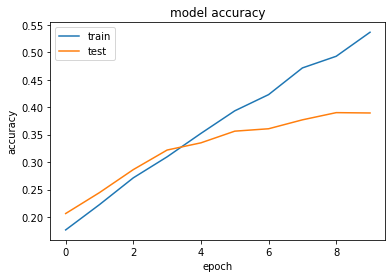

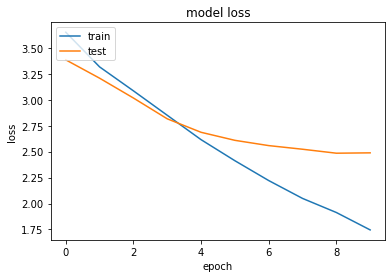

In [0]:
# Entrée 01
model_title = Sequential()
model_title.add(Embedding(embedding_matrix_title.shape[0], embedding_matrix_title.shape[1], input_length = INPUT_LENGTH_TITLE,
                          weights=[embedding_matrix_title], 
                          trainable=True,
                          ))
model_title.add(SpatialDropout1D(0.5))
model_title.add(Bidirectional(LSTM(LSTM_OUT)))
model_title.add(Dropout(0.2))

# Entrée 02
model_abstract = Sequential()
model_abstract.add(Embedding(embedding_matrix_abstract.shape[0], embedding_matrix_abstract.shape[1], input_length = INPUT_LENGTH_ABSTRACT,
                           weights=[embedding_matrix_abstract], 
                           trainable=True
                             ))
model_abstract.add(SpatialDropout1D(0.5))
model_abstract.add(Bidirectional(LSTM(LSTM_OUT)))
model_abstract.add(Dropout(0.2))

# Concaténation
concat_layers = concatenate([model_title.output, model_abstract.output], axis=-1)
layer = Dense(OUTPUT)(concat_layers)
outlayer = Activation('softmax')(layer)
model = Model([model_title.input, model_abstract.input], [outlayer])

# Compilation
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())
history = model.fit([np.array(X_train_title_seq), np.array(X_train_abstract_seq)], np.array(Y_train_id), batch_size = 256, epochs = 10,
verbose = VERBOSE, validation_split = VALIDATION_SPLIT)
score = model.evaluate([np.array(X_test_title_seq), np.array(X_test_abstract_seq)], np.array(Y_test_id), verbose = VERBOSE)
print("Test loss:", score[0])
print('Test accuracy:', score[1])

# list de données dans l'historique
print(history.history.keys())

# plot pour comparer accuracy et validate accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

# plot pour comparer loss et validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

In [0]:
# Définir le modèle
model_CNN_abstract = Sequential()
model_CNN_abstract.add(Embedding(embedding_matrix_abstract.shape[0], embedding_matrix_abstract.shape[1], 
                       input_length = INPUT_LENGTH_ABSTRACT, 
                       weights=[embedding_matrix_abstract], 
                       trainable=True))
model_CNN_abstract.add(Conv1D(filters = FILTERS, kernel_size = KERNEL_SIZE))
model_CNN_abstract.add(BatchNormalization(axis=-1))
model_CNN_abstract.add(Activation('relu'))
model_CNN_abstract.add(Dropout(0.1))
model_CNN_abstract.add(GlobalMaxPooling1D())
model_CNN_abstract.add(Dense(OUTPUT))
model_CNN_abstract.add(Activation('softmax'))
print(model_CNN_abstract.summary())

# Compiler le modèle
model_CNN_abstract.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_CNN_abstract.fit(X_train_abstract_seq, Y_train_id,  epochs = 15,  verbose = VERBOSE, 
                                 validation_split = VALIDATION_SPLIT, batch_size = BATCH_SIZE)
score = model_CNN_abstract.evaluate(X_test_abstract_seq, Y_test_id)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 1200, 300)         12193200  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1198, 200)         180200    
_________________________________________________________________
batch_normalization_3 (Batch (None, 1198, 200)         800       
_________________________________________________________________
activation_9 (Activation)    (None, 1198, 200)         0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 1198, 200)         0         
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 200)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 97)               